# CLASIFICADOR RESIDUOS PACTIA

## Librerías

In [ ]:
from google.colab import drive
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import RMSprop
from joblib import Parallel, delayed
from sklearn.metrics import classification_report


## Lectura de imágenes

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Rutas
root_folder = '/content/drive/MyDrive/clasificador_residuos'
data_folder = os.path.join(root_folder, 'Datos')

# Nombre de las carpetas
class_folders = [
    'basura',
    'carton',
    'medico',
    'metal',
    'organico',
    'papel',
    'plastico',
    'tecno',
    'vidrio'
]

# Diccionario de etiquetas
map_labels = {
    0: 'basura', 1: 'carton', 2: 'medico',
    3: 'metal', 4: 'organico', 5: 'papel', 6: 'plastico',
    7: 'tecno', 8: 'vidrio'
}

In [ ]:
# Lectura y resize de las imágenes

# Tamaño de las imágenes
image_size = (150, 150)

# Lista para almacenar las imágenes y las etiquetas
images = []
labels = []

# Leer las imágenes de cada carpeta de clase
for i, class_folder in enumerate(class_folders):
    # Ruta de la carpeta de clase en Google Drive
    class_path = os.path.join(data_folder, class_folder)

    # Leer los archivos de imagen en la carpeta de clase
    image_files = os.listdir(class_path)

    # Leer y procesar las imágenes
    for filename in image_files:
        # Ruta completa de la imagen
        image_path = os.path.join(class_path, filename)

        try:
            # Leer la imagen con PIL
            image = Image.open(image_path)

            # Redimensionar la imagen
            image = image.resize(image_size)

            # Convertir la imagen a un array numpy
            image_array = img_to_array(image)

            # Verificar la forma de la imagen
            if image_array.shape == (150, 150, 3):
                # Agregar la imagen y la etiqueta a las listas
                images.append(image_array)
                labels.append(i)  # Usar el índice como etiqueta de clase
            else:
                print(f"Imagen descartada debido a una forma incorrecta: {image_path}")

        except:
            # Omitir la imagen si no puede ser leída
            print(f"Error al leer la imagen: {image_path}. Saltando a la siguiente imagen.")
            continue

# Convertir las listas de imágenes y etiquetas a arrays numpy
images = np.array(images)
labels = np.array(labels)

# Verificar las formas de los datos finales
print('Shape de los datos de las imágenes:', images.shape)
print('Shape de los datos de las etiquetas:', labels.shape)

Error al leer la imagen: /content/drive/MyDrive/clasificador_residuos/Datos/basura/20230531_093620.heic. Saltando a la siguiente imagen.
Error al leer la imagen: /content/drive/MyDrive/clasificador_residuos/Datos/carton/cardboard 1075.jpg. Saltando a la siguiente imagen.
Imagen descartada debido a una forma incorrecta: /content/drive/MyDrive/clasificador_residuos/Datos/carton/cardboard 1876.jpg
Imagen descartada debido a una forma incorrecta: /content/drive/MyDrive/clasificador_residuos/Datos/carton/cardboard 2262.jpg
Imagen descartada debido a una forma incorrecta: /content/drive/MyDrive/clasificador_residuos/Datos/carton/cardboard 2351.jpg
Imagen descartada debido a una forma incorrecta: /content/drive/MyDrive/clasificador_residuos/Datos/carton/cardboard 1909.jpg
Imagen descartada debido a una forma incorrecta: /content/drive/MyDrive/clasificador_residuos/Datos/carton/cardboard 1650.jpg
Imagen descartada debido a una forma incorrecta: /content/drive/MyDrive/clasificador_residuos/Dato

In [ ]:
# Obtiene los índices de las imágenes con etiqueta 4
indices_label_4 = np.where(labels == 4)[0]

# Calcula cuántas imágenes corresponde al 60% de la etiqueta 4
num_images_to_remove = int(len(indices_label_4) * 0.6)

# Genera una permutación aleatoria de los índices de la etiqueta 1
perm = np.random.permutation(len(indices_label_4))

# Obtiene los índices a eliminar
indices_to_remove = indices_label_4[perm[:num_images_to_remove]]

# Elimina las imágenes y etiquetas correspondientes a los índices a eliminar
images = np.delete(images, indices_to_remove, axis=0)
labels = np.delete(labels, indices_to_remove)

# Verificar las formas de los datos finales
print('Shape de los datos de las imágenes:', images.shape)
print('Shape de los datos de las etiquetas:', labels.shape)

Shape de los datos de las imágenes: (21343, 150, 150, 3)
Shape de los datos de las etiquetas: (21343,)


In [ ]:
image_files=[]
test=[]
indices_label_4=[]
indices_to_remove=[]
perm=[]

## Modelado

### Preprocesamiento

In [ ]:
# Se normalizan las entradas
images = images/255

In [ ]:
# Obtener la longitud de los arrays de imágenes y etiquetas
num_samples = len(labels)

In [ ]:
# Generar una permutación aleatoria de los índices
perm = np.random.permutation(num_samples)

In [ ]:
# Permutar los índices de los arrays de imágenes y etiquetas
images = images[perm]
labels = labels[perm]

### Análisis de datos

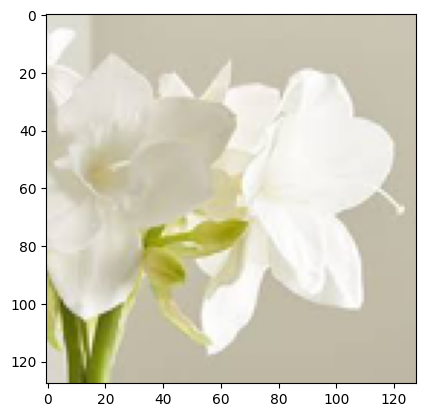

In [ ]:
# Gráfica de una imagen
plt.imshow(images[120])
plt.show()

In [ ]:
print(labels[120])

4


In [ ]:
#Separa datos de train y validación
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=123)
images=[]
labels=[]

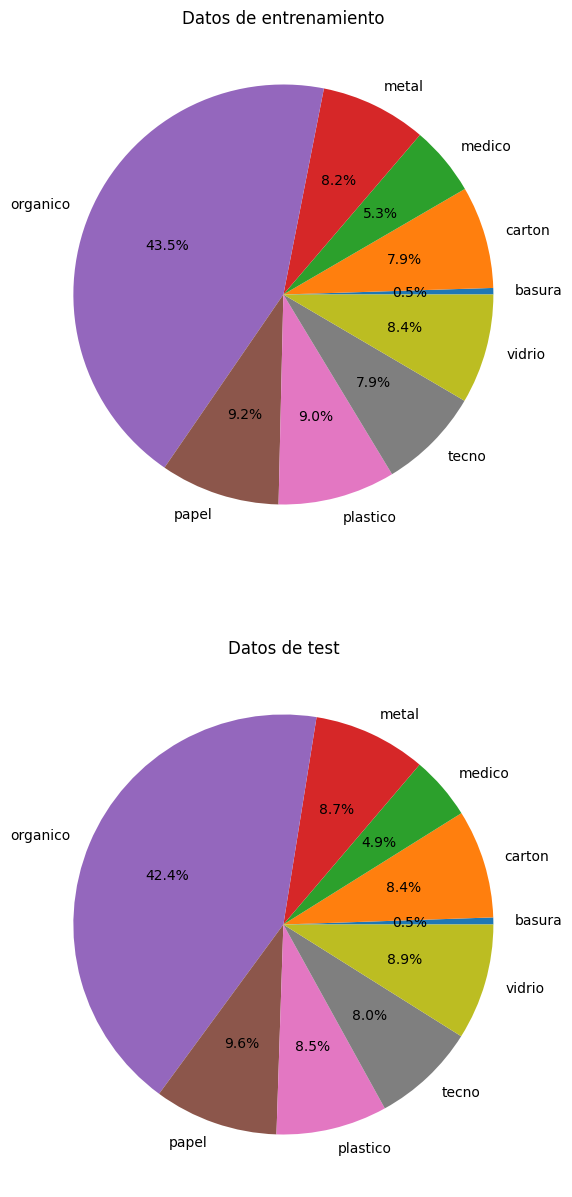

In [ ]:
# Torta de etiquetas
import pandas as pd

#Crea dataframe de las etiquetas de entrenamiento y test
entrenamiento=pd.DataFrame()
test=pd.DataFrame()

entrenamiento['Etiqueta']=y_train
entrenamiento=entrenamiento.replace({'Etiqueta': map_labels}, regex=True)

test['Etiqueta']=y_val
test=test.replace({'Etiqueta': map_labels}, regex=True)

#Hace un conteo de las etiquetas
torta_train=entrenamiento['Etiqueta'].value_counts().reset_index().rename(columns={'index':'Clasificacion',
                                                               'Etiqueta':'Conteo'}).sort_values(by=['Clasificacion'])

torta_test=test['Etiqueta'].value_counts().reset_index().rename(columns={'index':'Clasificacion',
                                                               'Etiqueta':'Conteo'}).sort_values(by=['Clasificacion'])


#Gráfico de torta
fig, ax=plt.subplots(2,1, figsize=(15,15))

ax[0].pie(torta_train['Conteo'], labels=torta_train['Clasificacion'], autopct='%1.1f%%')
ax[0].set_title('Datos de entrenamiento')

ax[1].pie(torta_test['Conteo'], labels=torta_test['Clasificacion'], autopct='%1.1f%%')
ax[1].set_title('Datos de test')

plt.show()

### Modelos

In [ ]:
#Se categorizan las etiquetas
y_train = keras.utils.to_categorical(y_train, 9)
y_val = keras.utils.to_categorical(y_val, 9)

In [ ]:
entrenamiento=[]
image_files=[]
perm=[]
test=[]
torta_test=[]
torta_train=[]

#### Data augmentation, callback y RMSprop

In [ ]:
# Crea el generador de imágenes

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

In [ ]:
#Callback para frenar el entrenamiento en un accuracy mayor a 0.74
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')> 0.74):
              print("\nAlcanzado el 74% de accuracy, se cancela el entrenamiento!!")
              self.model.stop_training = True

callbacks = myCallback()

In [ ]:
#Red 1
cnn1 = tf.keras.Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])

# Compilar modelo
cnn1.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar modelo
modelo1 = cnn1.fit_generator(datagen.flow(X_train, y_train,batch_size=32),
                              steps_per_epoch=len(X_train) // 32,
                              epochs=200, validation_data=(X_val, y_val), callbacks=[callbacks])

<ipython-input-17-3cb908539be4>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo2 = cnn2.fit_generator(datagen.flow(X_train, y_train,batch_size=32),


Epoch 1/200
  6/533 [..............................] - ETA: 3:43 - loss: 2.2023 - accuracy: 0.1302

533/533 [==============================] - 273s 488ms/step - loss: 1.9190 - accuracy: 0.2770 - val_loss: 1.8552 - val_accuracy: 0.3092
Epoch 2/200
533/533 [==============================] - 247s 463ms/step - loss: 1.8319 - accuracy: 0.3211 - val_loss: 1.7330 - val_accuracy: 0.3907
Epoch 3/200
533/533 [==============================] - 246s 462ms/step - loss: 1.7413 - accuracy: 0.3832 - val_loss: 1.7063 - val_accuracy: 0.3849
Epoch 4/200
533/533 [==============================] - 247s 462ms/step - loss: 1.6779 - accuracy: 0.4058 - val_loss: 1.5825 - val_accuracy: 0.4315
Epoch 5/200
533/533 [==============================] - 247s 463ms/step - loss: 1.6214 - accuracy: 0.4221 - val_loss: 1.5356 - val_accuracy: 0.4556
Epoch 6/200
533/533 [==============================] - 246s 462ms/step - loss: 1.5753 - accuracy: 0.4483 - val_loss: 1.4705 - val_accuracy: 0.4828
Epoch 7/200
533/533 [==============================] - 246s 462ms/step - loss: 1.5293 - accuracy: 0.4686 - val_loss: 1.4775 - val_

In [ ]:
#Hace las predicciones
y_pred=cnn2.predict(X_val)

#Imprime el reporte de clasificación


134/134 [==============================] - 15s 109ms/step


In [ ]:
print(classification_report(np.where(y_val > 0)[1],
                      np.argmax(y_pred, axis=1),
                      target_names=list(map_labels.values())), sep='')

              precision    recall  f1-score   support

      basura       0.58      0.58      0.58        26
      carton       0.76      0.82      0.79       433
      medico       0.66      0.59      0.63       302
       metal       0.71      0.72      0.72       453
    organico       0.85      0.94      0.89      1027
       papel       0.77      0.67      0.72       538
    plastico       0.67      0.62      0.65       531
       tecno       0.69      0.74      0.72       448
      vidrio       0.72      0.69      0.71       511

    accuracy                           0.75      4269
   macro avg       0.71      0.71      0.71      4269
weighted avg       0.75      0.75      0.75      4269



In [ ]:
# Se guarda el modelo
cnn1.save('/content/drive/MyDrive/clasificador_residuos/modelo1_entrenado.h5')

#### Data augmentation, callback, Adam y mas capas

In [ ]:
cnn2 = tf.keras.Sequential([
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.5),
     layers.Dense(512, activation='relu'),
    layers.Dense(9, activation='softmax')
])

# Compilar modelo
cnn2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar modelo
modelo2 = cnn2.fit(datagen.flow(X_train, y_train,batch_size=32),
                              steps_per_epoch=len(X_train) // 32,
                              epochs=200, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/200
  6/533 [..............................] - ETA: 16:58 - loss: 2.1895 - accuracy: 0.2031

533/533 [==============================] - 1177s 2s/step - loss: 2.0583 - accuracy: 0.2354 - val_loss: 2.0597 - val_accuracy: 0.2272
Epoch 2/200
533/533 [==============================] - 1052s 2s/step - loss: 2.0545 - accuracy: 0.2359 - val_loss: 2.0601 - val_accuracy: 0.2272
Epoch 3/200
533/533 [==============================] - 1050s 2s/step - loss: 2.0542 - accuracy: 0.2355 - val_loss: 2.0565 - val_accuracy: 0.2272
Epoch 4/200
533/533 [==============================] - 1047s 2s/step - loss: 2.0529 - accuracy: 0.2358 - val_loss: 2.0562 - val_accuracy: 0.2272
Epoch 5/200
467/533 [=========================>....] - ETA: 2:02 - loss: 2.0521 - accuracy: 0.2364

KeyboardInterrupt: ignored